In [1]:
pip install torch==1.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 999.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 60.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.13.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install transformers==4.26.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [3]:
!pip install pytorch-lightning==1.9.3 -qq

In [4]:
!pip install torchmetrics==0.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 kB 8.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.0.0
    Uninstalling torchmetrics-1.0.0:
      Successfully uninstalled torchmetrics-1.0.0


# Imports

In [5]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [6]:
import os

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
from transformers import AutoTokenizer as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [9]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc # no f1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [10]:
from sklearn import metrics

In [11]:
from pytorch_lightning.callbacks import TQDMProgressBar

In [12]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

# Classes

In [13]:
class EmoteDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        chats = data_row.chats
        labels = data_row[LABEL_COLUMNS]

        encoding = self.tokenizer.encode_plus(
            chats,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            chats=chats,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [14]:
class EmoteDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
    
  def setup(self, stage=None):
    self.train_dataset = EmoteDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = EmoteDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [15]:
class EmoteTagger(pl.LightningModule):
    def __init__(self, bert, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
          for out_labels in output["labels"].detach().cpu():
            labels.append(out_labels)
          for out_predictions in output["predictions"].detach().cpu():
            predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        print(labels.size(), predictions.size())

        for i, name in enumerate(LABEL_COLUMNS):
          class_roc_auc = auroc(task="binary", num_classes=NUM_CLASSES, preds=predictions[:, i], target=labels[:, i])
          self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=5e-5)  # 2e-5

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

# Main

(32063, 6) (5659, 6)


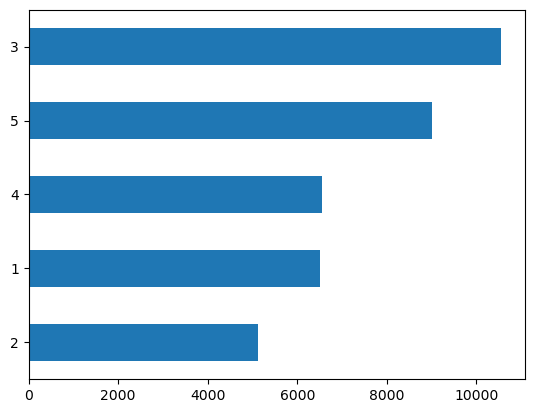

In [16]:
train_path = '/kaggle/input/emote-test-top-5/train5.csv'
df = pd.read_csv(train_path)
df.dropna(inplace=True)
df.head()

LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df[LABEL_COLUMNS].values)
print(train_df.shape, val_df.shape)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# specify max number of tokens
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["chats"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

MAX_TOKEN_COUNT = 150

bert_model = BertModel.from_pretrained(model_name, return_dict=True)

# freeze layers: all embeddings, first 5 encoder
modules = [bert_model.embeddings, *bert_model.encoder.layer[:5]] 
for module in modules:
    for param in module.parameters():
       param.requires_grad = False

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
N_EPOCHS = 4
BATCH_SIZE = 32
NUM_CLASSES = 5

In [20]:
data_module = EmoteDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

model = EmoteTagger(
    bert=bert_model,
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="chats")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

progress_bar_callback = TQDMProgressBar(refresh_rate=30)

trainer = pl.Trainer(
  logger=logger,
  enable_checkpointing=True,
  callbacks=[early_stopping_callback, checkpoint_callback, progress_bar_callback],
  max_epochs=N_EPOCHS,
  accelerator='gpu',
  devices=1
)
  

In [21]:
trainer.fit(model, data_module)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
torch.Size([32063, 5]) torch.Size([32063, 5])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELI

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
torch.Size([32063, 5]) torch.Size([32063, 5])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELI

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
torch.Size([32063, 5]) torch.Size([32063, 5])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELI

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
torch.Size([32063, 5]) torch.Size([32063, 5])


In [22]:
trainer.test(dataloaders=data_module.train_dataloader())

trainer.test(dataloaders=data_module.val_dataloader())

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.36194443702697754    │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.38019415736198425    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.38019415736198425}]

In [23]:
trained_model = EmoteTagger.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    bert=bert_model,
    n_classes=len(LABEL_COLUMNS)
)

torch.save({'model_state_dict':trained_model.state_dict()}, f'/kaggle/working/trained_model.pth')

# Sample chat test

In [24]:
Dict = {'1': 'joebartBusiness', '2': 'joebartLongneck', '3': 'joebartWeBelieve', '4': 'LUL', '5': 'catJAM'}
Dict = dict((k, v.lower()) for k, v in Dict.items())

test_model = EmoteTagger(
  bert=bert_model,
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

best = torch.load('/kaggle/working/trained_model.pth')

test_model.load_state_dict(best['model_state_dict'])

test_model.to(device)
print(device)

test_model.eval()
test_model.freeze()

test_comment = "Today is a good day"

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.to(device)

_, test_prediction = test_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.cpu() # numpy doesn't work with gpu
test_prediction = test_prediction.flatten().numpy()

result = ["", 0]

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")
  if (prediction > result[1]):
        result = [label, prediction]

print('\n')
print('final prediction:', Dict[result[0]])

cuda
1: 0.18968549370765686
2: 0.13521943986415863
3: 0.377373069524765
4: 0.14633584022521973
5: 0.1981276273727417


final prediction: joebartwebelieve


# Metrics

In [25]:
val_dataset = EmoteDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset): 
  _, prediction = test_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

THRESHOLD = 0.5

print("accuracy:",accuracy(task="binary", threshold=THRESHOLD, num_classes=NUM_CLASSES, preds=predictions, target=labels))

print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(task="binary", num_classes=NUM_CLASSES, preds=predictions[:, i], target=labels[:, i])
  print(f"{Dict[name]}: {tag_auroc}")

y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))


  0%|          | 0/5659 [00:00<?, ?it/s]

accuracy: tensor(0.8474)
AUROC per tag
joebartbusiness: 0.7154106497764587
joebartlongneck: 0.7189970016479492
joebartwebelieve: 0.7797983884811401
lul: 0.7613838911056519
catjam: 0.8677177429199219
              precision    recall  f1-score   support

           1       0.95      0.09      0.16       975
           2       0.93      0.17      0.29       769
           3       0.86      0.28      0.42      1582
           4       0.92      0.10      0.18       982
           5       0.89      0.57      0.70      1351

   micro avg       0.89      0.27      0.41      5659
   macro avg       0.91      0.24      0.35      5659
weighted avg       0.90      0.27      0.38      5659
 samples avg       0.27      0.27      0.27      5659

